In [4]:
################## IMPORT LIBRARIES ##################

from IPython.display import Audio
import numpy as np
import pandas as pd
from os.path import join as pjoin
import scipy.signal as sig
from IPython.display import Audio
from masp import shoebox_room_sim as srs
from scipy.io import wavfile
import matplotlib.pyplot as plt 
import sys

In [5]:
################## IMPORT MY MODULES ##################
sys.path.append('../src')

import helpers as hlp
import importlib
importlib.reload(hlp);

In [91]:
# parameters: 
N_pairs=10000 # number of rir pairs to generate
fs_rir = 48000
fs_target = 48000 
maxlim = 1.8 # Maximum reverberation time
band_centerfreqs=np.array([16000]) #change this for multiband
writepath=''
# Mic characteristics
mic_specs = np.array([[0, 0, 0, 1]]) # omni-directional
# mic_specs = np.array([[1, 0, 0, 0.5]])    # cardioid looking to the front
# mic_specs = np.array([[-1, 0, 0, 0.25]])  # hypercardioid looking backwards

In [92]:
# ----- CREATE A DATA FRAME WITH ROOM DEFINITIONS (ROOM DIMENSIONS AND RT60) -----

df_rooms=pd.DataFrame()

# set parameters of simulation
RT60_MIN=0.1
RT60_MAX=1.8
RT60_MEAN=0.6
RT60_STD=0.2
ALPHA_MIN=0.1
ALPHA_MAX=0.6
HEIGHT_MIN=2
HEIGHT_MAX=5

# initialize lists
rt60_set=[]
rt60_diff=[]
volume=[]
room_x=[]
room_y=[]
room_z=[]
pair_nr=[]
for k in range(N_pairs):
    pair_nr.append(k)
    pair_nr.append(k)

    # sample rt60 difference and fitting values fulfilling that difference
    rt60_r1, rt60_r2= hlp.generate_rt60_diff(RT60_MIN, RT60_MAX, RT60_MEAN, RT60_STD)
    rt60_diff.append(np.abs(rt60_r1-rt60_r2))
    rt60_diff.append(np.abs(rt60_r1-rt60_r2))
    
    # add rt60 to the list
    rt60_set.append(rt60_r1)
    rt60_set.append(rt60_r2)

    # compute possible range of volumes for a given rt60 and a range of absorbption coefficients 
    V_min_r1, V_max_r1 = hlp.find_volume_range(rt60_r1, ALPHA_MIN, ALPHA_MAX)
    V_min_r2, V_max_r2 = hlp.find_volume_range(rt60_r2, ALPHA_MIN, ALPHA_MAX)

    # create volumes and room dimensions for a given volume range
    vol_r1, Dx_r1, Dy_r1, Dz_r1 = hlp.generate_room_from_volume(V_min_r1, V_max_r1, z_min=HEIGHT_MIN,z_max=HEIGHT_MAX)
    vol_r2, Dx_r2, Dy_r2, Dz_r2 = hlp.generate_room_from_volume(V_min_r2, V_max_r2, z_min=HEIGHT_MIN,z_max=HEIGHT_MAX)

    # add volumes to the list
    volume.append(vol_r1)
    volume.append(vol_r2)
    # add x dims to the list
    room_x.append(Dx_r1)
    room_x.append(Dx_r2)
    # add y dims to the list
    room_y.append(Dy_r1)
    room_y.append(Dy_r2)
    # add z dims to the list
    room_z.append(Dz_r1)
    room_z.append(Dz_r2)

# fill data frame
df_rooms["pair_nr"]=pair_nr
df_rooms["rt60_diff"]=rt60_diff
df_rooms["rt60_set"]=rt60_set
df_rooms["volume"]=volume
df_rooms["room_x"]=room_x
df_rooms["room_y"]=room_y
df_rooms["room_z"]=room_z



In [ ]:
# ----- IN EACH ROOM GENERATE ONE MIC AND TWO SOURCES ----

# initialize a list of receiver positions in the room:
mic_pos_x = []
mic_pos_y = []
mic_pos_z = []
# initialize a list of source positions in the room:
src1_pos_x = []
src1_pos_y = []
src1_pos_z = []
# initialize a list of source clone positions in the room:
src2_pos_x = []
src2_pos_y = []
src2_pos_z = []

for k in range(N_pairs*2):
    Dx=df_rooms.loc[k,"room_x"]
    Dy=df_rooms.loc[k,"room_y"]
    # generate position of the mic inside the room
    x_mic,y_mic,z_mic = hlp.place_inside_room(Dx, Dy, margin_x=0.25, margin_y=0.25, z_range=(1.0, 2.0))
    # generate position of the source inside the room (at least 0.3m from the mic)
    x_src1,y_src1,z_src1 = hlp.place_inside_room(Dx, Dy, margin_x=0.1, margin_y=0.1, z_range=(1.0, 2.0),avoid_position=[x_mic,y_mic,z_mic])
    x_src2,y_src2,z_src2 = hlp.place_inside_room(Dx, Dy, margin_x=0.1, margin_y=0.1, z_range=(1.0, 2.0),avoid_position=[x_mic,y_mic,z_mic])
    # append to the list of mic positions
    mic_pos_x.append(x_mic)
    mic_pos_y.append(y_mic)
    mic_pos_z.append(z_mic)
    # append to the list of source positions
    src1_pos_x.append(x_src1)
    src1_pos_y.append(y_src1)
    src1_pos_z.append(z_src1)
    # append to the list of source clone positions
    src2_pos_x.append(x_src2)
    src2_pos_y.append(y_src2)
    src2_pos_z.append(z_src2)

# fill data frame
df_rooms["mic_pos_x"]=mic_pos_x
df_rooms["mic_pos_y"]=mic_pos_y
df_rooms["mic_pos_z"]=mic_pos_z

df_rooms["src1_pos_x"]=src1_pos_x
df_rooms["src1_pos_y"]=src1_pos_y
df_rooms["src1_pos_z"]=src1_pos_z

df_rooms["src2_pos_x"]=src2_pos_x
df_rooms["src2_pos_y"]=src2_pos_y
df_rooms["src2_pos_z"]=src2_pos_z

# Add empty columns to be filled by a multiprocessing function
df_rooms['rt60_true'] = ''
df_rooms['rt60_masp_stats'] = ''
df_rooms['cd_masp_stats'] = ''
df_rooms['mfp_masp_stats'] = ''
df_rooms['rt30_meas'] = ''
df_rooms['rt20_meas'] = ''
df_rooms['edt_meas'] = ''
df_rooms['c50_meas'] = ''

# save dataframe with rooms (with 1 mic and 2 sources per room):
from datetime import datetime
date_tag = datetime.now().strftime("%d-%m-%Y--%H-%M")
df_rooms.to_csv("../dataset-metadata/"+ date_tag +"_room_info.csv")


NameError: name 'N_pairs' is not defined

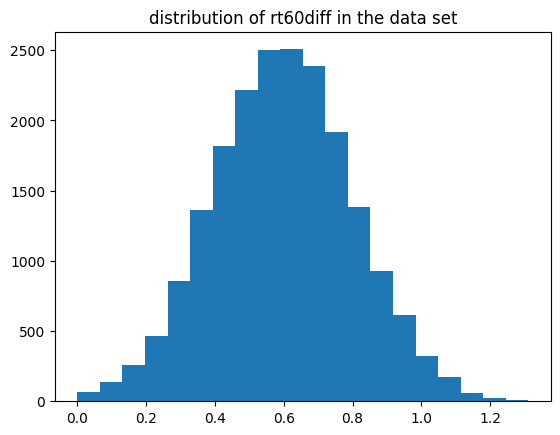

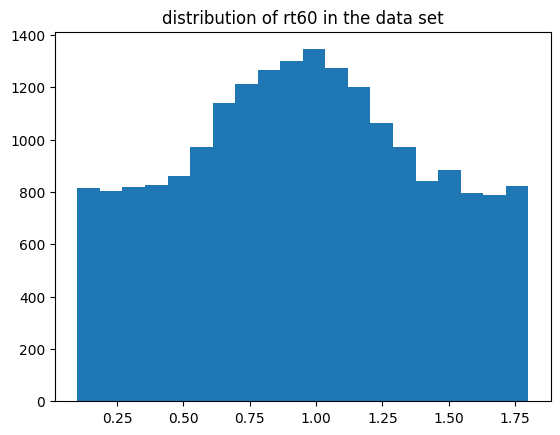

,Unnamed: 0,pair_nr,rt60_diff,rt60_set,volume,room_x,room_y,room_z,mic_pos_x,mic_pos_y,...,src2_pos_y,src2_pos_z,rt60_true,rt60_masp_stats,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas
0,0,0,0.631,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,...,4.234205,1.986758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0.631,0.156,31.55,3.32,3.40,2.80,2.260720,2.205862,...,1.263116,1.058180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,0.535,0.850,2400.35,15.57,24.34,6.33,8.942463,11.514995,...,9.564130,1.985106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,0.535,0.315,321.88,12.39,12.99,2.00,6.333618,8.180149,...,9.830835,1.092860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2,0.676,1.583,1294.94,15.02,20.49,4.21,10.186720,6.618432,...,16.520835,1.608907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2,0.676,0.907,1598.62,19.03,32.37,2.59,10.666443,13.634136,...,22.044475,1.988637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,3,0.539,0.734,1054.05,15.76,16.26,4.11,6.530253,4.180622,...,10.167257,1.153742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,3,0.539,0.195,38.74,4.17,4.23,2.20,1.163764,2.271186,...,3.320945,1.509094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,4,0.471,0.267,94.25,4.54,4.60,4.51,2.763648,2.309397,...,1.944280,1.216729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,4,0.471,0.738,722.25,10.96,14.08,4.68,5.494016,8.252775,...,6.113503,1.035079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_rooms=pd.read_csv("../dataset-metadata/11-02-2025--17-16_room_info.csv")

# Pairs of rooms with control difference in rt60 are defined by indices 0&1,2&3,4&5, etc... 
# [2k & 2k+1 for k in range(0,N_pairs)])

plt.figure()
plt.hist(df_rooms["rt60_diff"],bins =20)
plt.title("distribution of rt60diff in the data set")
plt.show()


plt.figure()
plt.hist(df_rooms["rt60_set"],bins =20)
plt.title("distribution of rt60 in the data set")
plt.show()


df_rooms.head(20)

In [1]:
# ---------------- GENERATE RIRS WITH MASP BASED ON METADATA AND COMPUTE RIR STATS ---------------

# Go to the script src/generate_rirs.py and execute: 
# python3 render_rirs.py "/home/ubuntu/Data/synth_rirs_new"  "/home/ubuntu/joanna/reverb-match-cond-u-net/dataset-metadata/11-02-2025--17-16_room_info.csv"
# the rirs and the file rir_info.csv (containing room info and rir stats) are saved in the folder "/home/ubuntu/Data/synth_rirs_new" 

In [ ]:
# ----- LISTEN TO REVERBERANT AUDIOS: -----


df_rooms_with_stats=pd.read_csv("/home/ubuntu/Data/synth_rirs_new/rir_info.csv")

for i in range(5):
    # room impulse response
    fs_rir, rir_data = wavfile.read(df_rooms_with_stats.loc[i,"ir_file_path"]) 
    # speech
    fs_speech, speech_data = wavfile.read("sounds/dial1p1.wav") 
    # create reverberant version of speech 
    revspeech_data=sig.fftconvolve(speech_data,rir_data, 'full', 0)
    # print corresponding rt60
    print("t60="+ str(df_rooms_with_stats.loc[i,"rt60_set"]))
    # audio player
    display(Audio(data=revspeech_data,rate=fs_speech))
